In [1]:
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
import torch.optim as optim
from torchvision import transforms, models

In [2]:
device = torch.device("mps")

content_layer = "conv4_2"

style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

content_weight = 1  # alpha
style_weight = 1e6  # beta


In [3]:
def gram_matrix(tensor):
    b, d, h, w = tensor.size()
    tensor = tensor.view(d, h*w)
    return torch.mm(tensor, tensor.t()) 


class StyleTransferModel(nn.Module):
    def __init__(self):
        super(StyleTransferModel, self).__init__()
        self.model = models.vgg19(weights="DEFAULT").features
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        self.model.to(device)

    def forward(self, image):
        layers = {'0': 'conv1_1',
                 '5':  'conv2_1',
                 '10': 'conv3_1',
                 '19': 'conv4_1',
                 '21': 'conv4_2',
                 '28': 'conv5_1'}
            
        features = {}
        x = image
    
        for i, layer in enumerate(self.model):
            name = str(i)
            x = layer(x)
            if name in layers:
                features[layers[name]] = x
                
        return features

class StyleLoss(nn.Module):
    def __init__(self, style_features, style_weights):
        super(StyleLoss, self).__init__()
        self.style_grams = {layer: gram_matrix(style_features[layer]).detach() for layer in style_features}
        self.style_weights = style_weights



    def forward(self, target_features):
        style_loss = 0
        for layer in self.style_weights:
            # Get the "target" style representation for the layer
            target_feature = target_features[layer]
            _, d, h, w = target_feature.shape
            target_gram = gram_matrix(target_feature)
    
            layer_style_loss = style_weights[layer] * nn.functional.mse_loss(target_gram, self.style_grams[layer])
            
            style_loss += layer_style_loss / (d * h * w)
        return style_loss
        

class ContentLoss(nn.Module):
    def __init__(self, target_feature):
        super(ContentLoss, self).__init__()
        self.target = target_feature.detach()

    def forward(self, x):
        return nn.functional.mse_loss(x, self.target)

In [4]:
def load_image(img_path, max_size=400, shape=None):
    
    image = Image.open(img_path).convert('RGB')
    
    size = min(max(image.size), max_size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    return in_transform(image).unsqueeze(0)

In [5]:
# load in content and style image
content = load_image('content.jpg').to(device)

style = load_image('style_chin.webp', shape=content.shape[-2:]).to(device)

In [6]:
def im_convert(tensor):

    image = tensor.clone().detach().cpu().numpy()
    image = image.squeeze().transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

## Content and Style Features

In [ ]:
style_transfer_model = StyleTransferModel().to(device)

content_features = style_transfer_model(content)
style_features = style_transfer_model(style)

target = content.clone().requires_grad_(True).to(device)

content_loss_module = ContentLoss(content_features[content_layer]).to(device)
style_loss_module = StyleLoss(style_features, style_weights).to(device)

optimizer = optim.LBFGS([target])

show_every = 10
steps = 30

def closure():
    # Calculate the content loss
    target_features = style_transfer_model(target)
    
    content_loss = content_loss_module(target_features[content_layer])
    
    style_loss = style_loss_module(target_features)
        
    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    
    return total_loss

# Optimization loop using L-BFGS
for ii in range(1, steps+1):
    optimizer.step(closure)
    
    # Display intermediate images and print the loss
    if ii % show_every == 0:
        print('Iteration {}, Total loss: {}'.format(ii, closure().item()))
        plt.imshow(im_convert(target))
        plt.show()

## Display the Target Image

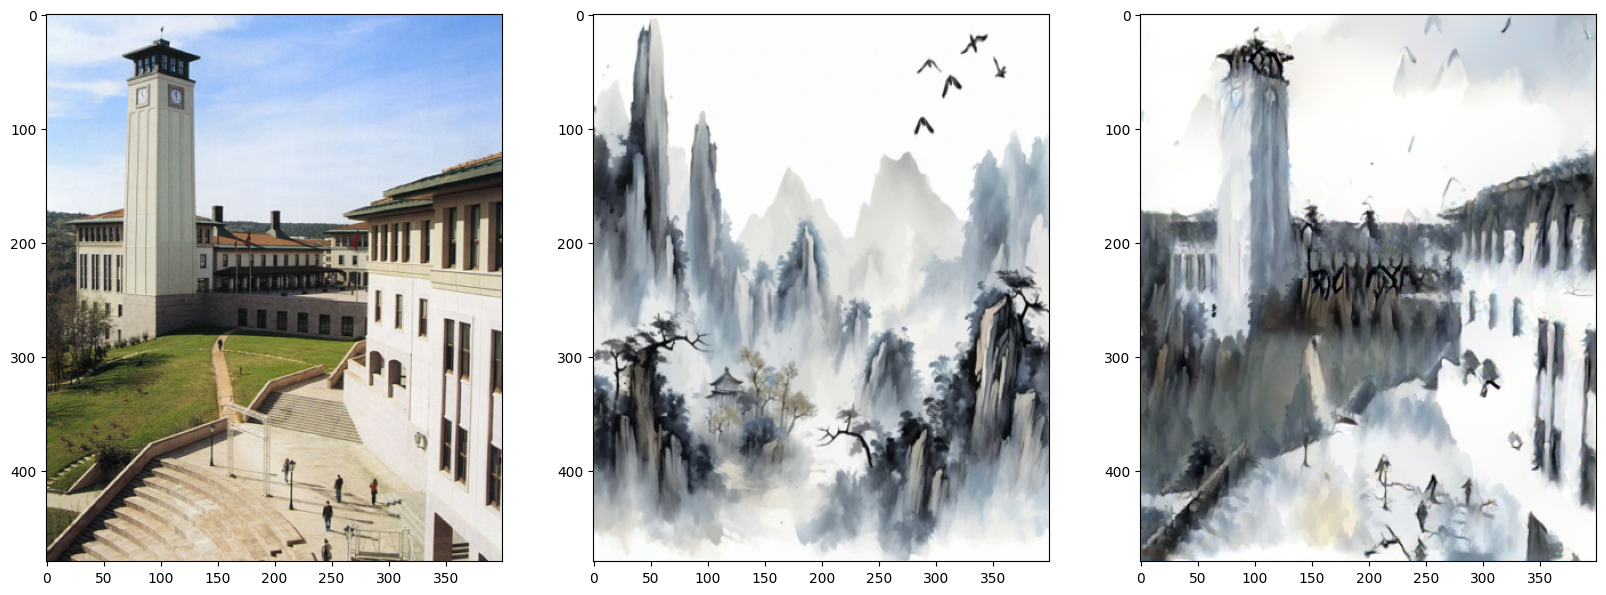

In [8]:
# display content and final, target image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))
ax3.imshow(im_convert(target))